In [19]:
class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()

        self.fc1 = nn.Linear(4, 32) #4 states
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 256) #hidden layer with 32 outputs and inputs
        self.fc3 = nn.Linear(256, 2) #2 actions

    def forward(self, state):
        y = self.relu(self.fc1(state))
        y = self.relu(self.fc2(y))
        Q = self.fc3(y)

        return Q

    #returns state with highest Q value
    def select_action(self, state):
        with torch.no_grad():
            Q = self.forward(state)
            action_index = torch.argmax(Q, dim=1)
        return action_index.item()


# The official Pytorch documentation has a class implementation of the ReplayBuffer. The implementation inspired me to make something and hence it is similar to the official one.

class Memory(object):
    def __init__(self, buffer_size: int) -> None:
        self.buffer_size = buffer_size
        self.buffer = deque(maxlen=self.buffer_size)

    def add(self, experience) -> None:
        self.buffer.append(experience)

    def size(self):
        return len(self.buffer)

    #making random memory
    def sample(self, batch_size: int, continuous: bool = True):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
            #continuous floats
        if continuous:
            rand = random.randint(0, len(self.buffer) - batch_size)
            return [self.buffer[i] for i in range(rand, rand + batch_size)]
          #random ints
        else:
            indexes = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
            return [self.buffer[i] for i in indexes]

    def clear(self):
        self.buffer.clear()


# Cartpole-v1 is solved when:
#     max_episode_steps=500,
#     reward_threshold=475.0

env = gym.make('CartPole-v1')
n_state = env.observation_space.shape[0]
n_action = env.action_space.n

onlineQNetwork = QNetwork().to(device)

if(os.path.isfile('dqn-policy.pt')):
  onlineQNetwork.load_state_dict(torch.load('dqn-policy.pt'))

targetQNetwork = QNetwork().to(device)
targetQNetwork.load_state_dict(onlineQNetwork.state_dict())


#Optimizer




# Hyperparameters 
GAMMA = 0.99
INITIAL_EPSILON = 0.9 #epsilon starting value
FINAL_EPSILON = 0.001 # minimum value of epsilon
EPSILON_DECAY = 0.980 # decay
BUFFER_SIZE = 50000 # size of replay buffer
BATCH = 128 # minibatch size
LR = 1e-4

# Using Adam with a Learning Rate of 0.0001
optimizer = torch.optim.Adam(onlineQNetwork.parameters(), lr=LR)

#Flow:
# Loop till done else break
# Select action based on epsilon
# Take action
# Add result to replay buffer
# If buffer size > minibatch (Train TargetNet every 4 steps)
# Update Q network
# Perform Loss
# Perform Epsilon Decay



UPDATE_EVERY = 4 


# graphing
totalreward=[]
losses = []

replay_buffer = Memory(BUFFER_SIZE)

epsilon = INITIAL_EPSILON
steps = 0

episode_reward = 0

for epoch in count():

    state = env.reset()
    episode_reward = 0
    for time_steps in range(500): #env states max 500 steps allowed
        p = random.random()
        if p < epsilon:
            action = random.randint(0, 1) #random action
        else:
            tensor_state = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = onlineQNetwork.select_action(tensor_state)               #argmax action
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        replay_buffer.add((state, next_state, action, reward, done))
        if replay_buffer.size() > 128:
            steps += 1

            #updating target network over every 4 steps
            if steps % UPDATE_EVERY == 0:
                targetQNetwork.load_state_dict(onlineQNetwork.state_dict())
            experience = replay_buffer.sample(BATCH, False)
            exp_state, exp_next_state, exp_action, exp_reward, exp_done = zip(*experience)
            # 'Unzipping' individual tuples

            #Converting experience to Tensors 

            exp_state = torch.FloatTensor(exp_state).to(device)
            exp_next_state = torch.FloatTensor(exp_next_state).to(device)
            exp_action = torch.FloatTensor(exp_action).unsqueeze(1).to(device)
            exp_reward = torch.FloatTensor(exp_reward).unsqueeze(1).to(device)
            exp_done = torch.FloatTensor(exp_done).unsqueeze(1).to(device)

            with torch.no_grad():
                targetQ_next = targetQNetwork(exp_next_state)
                y = exp_reward + (1 - exp_done) * GAMMA * torch.max(targetQ_next, dim=1, keepdim=True)[0] #DQN Update step


            # Simple MSE Loss
            loss = F.mse_loss(onlineQNetwork(exp_state).gather(1, exp_action.long()), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # epsilon decay
            if epsilon > FINAL_EPSILON:
                epsilon *= EPSILON_DECAY
            else:
                epsilon = FINAL_EPSILON

        if done:
            break
        state = next_state

    totalreward.append(episode_reward)
    if epoch % 10 == 0:
        torch.save(onlineQNetwork.state_dict(), 'dqn-policy.pt') #saving learning policy every 10 epochs
        print('Ep {}\Average Reward: {:.2f}\t'.format(epoch, episode_reward))
        

Ep 0\Average Reward: 17.00	
Ep 10\Average Reward: 16.00	
Ep 20\Average Reward: 12.00	
Ep 30\Average Reward: 10.00	
Ep 40\Average Reward: 8.00	
Ep 50\Average Reward: 8.00	
Ep 60\Average Reward: 8.00	
Ep 70\Average Reward: 11.00	
Ep 80\Average Reward: 9.00	
Ep 90\Average Reward: 11.00	
Ep 100\Average Reward: 14.00	
Ep 110\Average Reward: 25.00	
Ep 120\Average Reward: 21.00	
Ep 130\Average Reward: 31.00	
Ep 140\Average Reward: 18.00	
Ep 150\Average Reward: 19.00	
Ep 160\Average Reward: 18.00	
Ep 170\Average Reward: 18.00	
Ep 180\Average Reward: 26.00	
Ep 190\Average Reward: 67.00	
Ep 200\Average Reward: 35.00	
Ep 210\Average Reward: 62.00	
Ep 220\Average Reward: 65.00	
Ep 230\Average Reward: 81.00	
Ep 240\Average Reward: 178.00	
Ep 250\Average Reward: 101.00	
Ep 260\Average Reward: 160.00	
Ep 270\Average Reward: 150.00	
Ep 280\Average Reward: 239.00	
Ep 290\Average Reward: 282.00	
Ep 300\Average Reward: 272.00	
Ep 310\Average Reward: 204.00	
Ep 320\Average Reward: 169.00	
Ep 330\Average R

KeyboardInterrupt: ignored

In [20]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

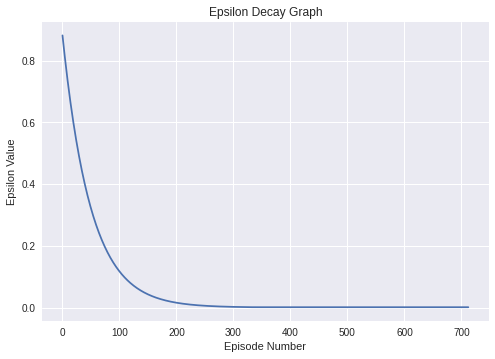

In [12]:
#epsilon decay graph
epsilons = []
epsilon = INITIAL_EPSILON
for i in range(epoch):
  if epsilon > FINAL_EPSILON:
    epsilon *= EPSILON_DECAY
  else:
    epsilon = FINAL_EPSILON
  epsilons.append(epsilon)


plt.plot(epsilons)
plt.title('Epsilon Decay Graph')
plt.xlabel('Episode Number')
plt.ylabel('Epsilon Value')
plt.show()

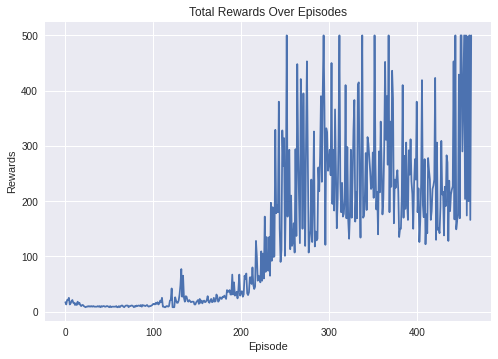

In [21]:
#rewards graph
plt.plot(totalreward)
plt.title('Total Rewards Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.show()

In [22]:
onlineQNetwork = QNetwork().to(device)
onlineQNetwork.load_state_dict(torch.load('dqn-policy.pt'))
targetQNetwork = QNetwork().to(device)
targetQNetwork.load_state_dict(onlineQNetwork.state_dict())


#Optimizer

optimizer = torch.optim.Adam(onlineQNetwork.parameters(), lr=1e-4)


#Hyperparameters 
GAMMA = 0.99

REPLAY_MEMORY = 50000 # size of replay buffer
BATCH = 128 # minibatch size


UPDATE_EVERY = 4 


# graphing
totalreward_train=[]
losses_train = []

memory_replay = Memory(REPLAY_MEMORY)


learn_steps = 0

episode_reward = 0

for epoch in range(5):

    state = env.reset()
    episode_reward = 0
    for time_steps in range(500):
      # uncomment to render
        # env.render()
        tensor_state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = onlineQNetwork.select_action(tensor_state)               #argmax action
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward

        if done:
            break
        state = next_state

    totalreward_train.append(episode_reward)

    print('Ep {}\Average Reward: {:.2f}\t'.format(epoch, episode_reward))
        

Ep 0\Average Reward: 247.00	
Ep 1\Average Reward: 500.00	
Ep 2\Average Reward: 236.00	
Ep 3\Average Reward: 251.00	
Ep 4\Average Reward: 230.00	


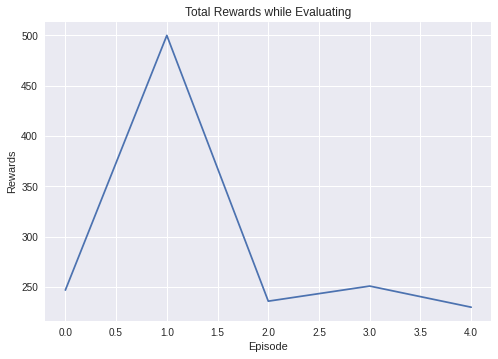

In [23]:
#rewards graph for eval
plt.plot(totalreward_train)
plt.title('Total Rewards while Evaluating')
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.show()

In [25]:
class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()

        #fully connected layers
        self.fc1 = nn.Linear(4, 32) #4 states
        self.relu = nn.ReLU()
        self.fc_value = nn.Linear(32, 64)
        self.fc_adv = nn.Linear(32, 64)

        self.value = nn.Linear(64, 1) # value function
        self.adv = nn.Linear(64, 2) # advantage function

    def forward(self, state):
        y = self.relu(self.fc1(state))
        value = self.relu(self.fc_value(y))
        adv = self.relu(self.fc_adv(y))

        value = self.value(value)
        adv = self.adv(adv)

        advAverage = torch.mean(adv, dim=1, keepdim=True)
        Q = value + adv - advAverage
        return Q

    def select_action(self, state):
        with torch.no_grad():
            Q = self.forward(state)
            action_index = torch.argmax(Q, dim=1)
        return action_index.item()

# The official Pytorch documentation has a class implementation of the ReplayBuffer. The implementation inspired me to make something and hence it is similar to the official one.

class Memory(object):
    def __init__(self, buffer_size: int) -> None:
        self.buffer_size = buffer_size
        self.buffer = deque(maxlen=self.buffer_size)

    def add(self, experience) -> None:
        self.buffer.append(experience)

    def size(self):
        return len(self.buffer)

    #making random memory
    def sample(self, batch_size: int, continuous: bool = True):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
            #continuous floats
        if continuous:
            rand = random.randint(0, len(self.buffer) - batch_size)
            return [self.buffer[i] for i in range(rand, rand + batch_size)]
          #random ints
        else:
            indexes = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
            return [self.buffer[i] for i in indexes]

    def clear(self):
        self.buffer.clear()


# Cartpole-v1 is solved when:
#     max_episode_steps=500,
#     reward_threshold=475.0

env = gym.make('CartPole-v1')
n_state = env.observation_space.shape[0]
n_action = env.action_space.n

onlineQNetwork = QNetwork().to(device)

if(os.path.isfile('dueling-dqn-policy.pt')):
  onlineQNetwork.load_state_dict(torch.load('dueling-dqn-policy.pt'))

targetQNetwork = QNetwork().to(device)
targetQNetwork.load_state_dict(onlineQNetwork.state_dict())


#Optimizer




# Hyperparameters 
GAMMA = 0.99
INITIAL_EPSILON = 0.9 #epsilon starting value
FINAL_EPSILON = 0.001 # minimum value of epsilon
EPSILON_DECAY = 0.980 # decay
BUFFER_SIZE = 50000 # size of replay buffer
BATCH = 128 # minibatch size
LR = 1e-4

# Using Adam with a Learning Rate of 0.0001
optimizer = torch.optim.Adam(onlineQNetwork.parameters(), lr=LR)

#Flow:
# Loop till done else break
# Select action based on epsilon
# Take action
# Add result to replay buffer
# If buffer size > minibatch (Train TargetNet every 4 steps)
# Update Q network
# Perform Loss
# Perform Epsilon Decay



UPDATE_EVERY = 4 


# graphing
totalreward=[]
losses = []

replay_buffer = Memory(BUFFER_SIZE)

epsilon = INITIAL_EPSILON
steps = 0

episode_reward = 0

for epoch in count():

    state = env.reset()
    episode_reward = 0
    for time_steps in range(500): #env states max 500 steps allowed
        p = random.random()
        if p < epsilon:
            action = random.randint(0, 1) #random action
        else:
            tensor_state = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = onlineQNetwork.select_action(tensor_state)               #argmax action
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        replay_buffer.add((state, next_state, action, reward, done))
        if replay_buffer.size() > 128:
            steps += 1

            #updating target network over every 4 steps
            if steps % UPDATE_EVERY == 0:
                targetQNetwork.load_state_dict(onlineQNetwork.state_dict())
            experience = replay_buffer.sample(BATCH, False)
            exp_state, exp_next_state, exp_action, exp_reward, exp_done = zip(*experience)
            # 'Unzipping' individual tuples

            #Converting experience to Tensors 

            exp_state = torch.FloatTensor(exp_state).to(device)
            exp_next_state = torch.FloatTensor(exp_next_state).to(device)
            exp_action = torch.FloatTensor(exp_action).unsqueeze(1).to(device)
            exp_reward = torch.FloatTensor(exp_reward).unsqueeze(1).to(device)
            exp_done = torch.FloatTensor(exp_done).unsqueeze(1).to(device)

            with torch.no_grad():
                targetQ_next = targetQNetwork(exp_next_state)
                y = exp_reward + (1 - exp_done) * GAMMA * torch.max(targetQ_next, dim=1, keepdim=True)[0] #DQN Update step


            # Simple MSE Loss
            loss = F.mse_loss(onlineQNetwork(exp_state).gather(1, exp_action.long()), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # epsilon decay
            if epsilon > FINAL_EPSILON:
                epsilon *= EPSILON_DECAY
            else:
                epsilon = FINAL_EPSILON

        if done:
            break
        state = next_state

    totalreward.append(episode_reward)
    if epoch % 10 == 0:
        torch.save(onlineQNetwork.state_dict(), 'dueling-dqn-policy.pt') #saving learning policy every 10 epochs
        print('Ep {}\Average Reward: {:.2f}\t'.format(epoch, episode_reward))
        

Ep 0\Average Reward: 35.00	
Ep 10\Average Reward: 13.00	
Ep 20\Average Reward: 9.00	
Ep 30\Average Reward: 10.00	
Ep 40\Average Reward: 10.00	
Ep 50\Average Reward: 10.00	
Ep 60\Average Reward: 11.00	
Ep 70\Average Reward: 8.00	
Ep 80\Average Reward: 10.00	
Ep 90\Average Reward: 11.00	
Ep 100\Average Reward: 9.00	
Ep 110\Average Reward: 8.00	
Ep 120\Average Reward: 11.00	
Ep 130\Average Reward: 8.00	
Ep 140\Average Reward: 11.00	
Ep 150\Average Reward: 11.00	
Ep 160\Average Reward: 10.00	
Ep 170\Average Reward: 11.00	
Ep 180\Average Reward: 9.00	
Ep 190\Average Reward: 11.00	
Ep 200\Average Reward: 10.00	
Ep 210\Average Reward: 12.00	
Ep 220\Average Reward: 12.00	
Ep 230\Average Reward: 14.00	
Ep 240\Average Reward: 10.00	
Ep 250\Average Reward: 10.00	
Ep 260\Average Reward: 10.00	
Ep 270\Average Reward: 9.00	
Ep 280\Average Reward: 10.00	
Ep 290\Average Reward: 9.00	
Ep 300\Average Reward: 13.00	
Ep 310\Average Reward: 13.00	
Ep 320\Average Reward: 10.00	
Ep 330\Average Reward: 12.00	

KeyboardInterrupt: ignored

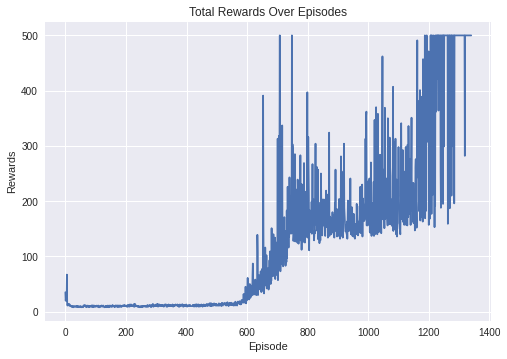

In [26]:
#rewards graph
plt.plot(totalreward)
plt.title('Total Rewards Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.show()

In [27]:
onlineQNetwork = QNetwork().to(device)
onlineQNetwork.load_state_dict(torch.load('dueling-dqn-policy.pt'))
targetQNetwork = QNetwork().to(device)
targetQNetwork.load_state_dict(onlineQNetwork.state_dict())


#Optimizer

optimizer = torch.optim.Adam(onlineQNetwork.parameters(), lr=1e-4)


#Hyperparameters 
GAMMA = 0.99

REPLAY_MEMORY = 50000 # size of replay buffer
BATCH = 128 # minibatch size


UPDATE_EVERY = 4 


# graphing
totalreward_train=[]
losses_train = []

memory_replay = Memory(REPLAY_MEMORY)


learn_steps = 0

episode_reward = 0

for epoch in range(5):

    state = env.reset()
    episode_reward = 0
    for time_steps in range(500):
      # uncomment to render
        # env.render()
        tensor_state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = onlineQNetwork.select_action(tensor_state)               #argmax action
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward

        if done:
            break
        state = next_state

    totalreward_train.append(episode_reward)

    print('Ep {}\Average Reward: {:.2f}\t'.format(epoch, episode_reward))
        

Ep 0\Average Reward: 500.00	
Ep 1\Average Reward: 500.00	
Ep 2\Average Reward: 500.00	
Ep 3\Average Reward: 500.00	
Ep 4\Average Reward: 500.00	


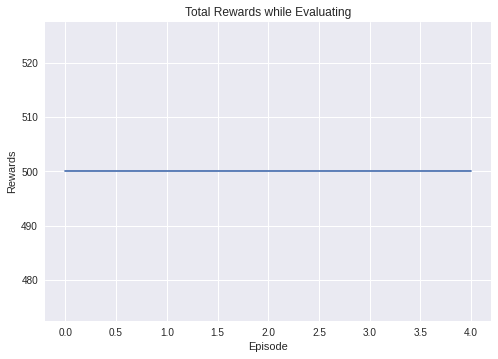

In [28]:
#rewards graph for eval
plt.plot(totalreward_train)
plt.title('Total Rewards while Evaluating')
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.show()

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()

        self.fc1 = nn.Linear(4, 64)
        self.relu = nn.ReLU()
        self.fc_value = nn.Linear(64, 256)
        self.fc_adv = nn.Linear(64, 256)

        self.value = nn.Linear(256, 1)
        self.adv = nn.Linear(256, 2)

    def forward(self, state):
        y = self.relu(self.fc1(state))
        value = self.relu(self.fc_value(y))
        adv = self.relu(self.fc_adv(y))

        value = self.value(value)
        adv = self.adv(adv)

        advAverage = torch.mean(adv, dim=1, keepdim=True)
        Q = value + adv - advAverage

        return Q

    def select_action(self, state):
        with torch.no_grad():
            Q = self.forward(state)
            action_index = torch.argmax(Q, dim=1)
        return action_index.item()


class Memory(object):
    def __init__(self, memory_size: int) -> None:
        self.memory_size = memory_size
        self.buffer = deque(maxlen=self.memory_size)

    def add(self, experience) -> None:
        self.buffer.append(experience)

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size: int, continuous: bool = True):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if continuous:
            rand = random.randint(0, len(self.buffer) - batch_size)
            return [self.buffer[i] for i in range(rand, rand + batch_size)]
        else:
            indexes = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
            return [self.buffer[i] for i in indexes]

    def clear(self):
        self.buffer.clear()


env = gym.make('CartPole-v0')
n_state = env.observation_space.shape[0]
n_action = env.action_space.n

onlineQNetwork = QNetwork().to(device)
targetQNetwork = QNetwork().to(device)
targetQNetwork.load_state_dict(onlineQNetwork.state_dict())

optimizer = torch.optim.Adam(onlineQNetwork.parameters(), lr=1e-4)

GAMMA = 0.99
EXPLORE = 20000
INITIAL_EPSILON = 0.1
FINAL_EPSILON = 0.0001
REPLAY_MEMORY = 50000
BATCH = 16

UPDATE_STEPS = 4

memory_replay = Memory(REPLAY_MEMORY)

epsilon = INITIAL_EPSILON
learn_steps = 0
begin_learn = False

episode_reward = 0

# onlineQNetwork.load_state_dict(torch.load('ddqn-policy.para'))
for epoch in count():

    state = env.reset()
    episode_reward = 0
    for time_steps in range(200):
        p = random.random()
        if p < epsilon:
            action = random.randint(0, 1)
        else:
            tensor_state = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = onlineQNetwork.select_action(tensor_state)
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        memory_replay.add((state, next_state, action, reward, done))
        if memory_replay.size() > 128:
            if begin_learn is False:
                print('learn begin!')
                begin_learn = True
            learn_steps += 1
            if learn_steps % UPDATE_STEPS == 0:
                targetQNetwork.load_state_dict(onlineQNetwork.state_dict())
            batch = memory_replay.sample(BATCH, False)
            batch_state, batch_next_state, batch_action, batch_reward, batch_done = zip(*batch)

            batch_state = torch.FloatTensor(batch_state).to(device)
            batch_next_state = torch.FloatTensor(batch_next_state).to(device)
            batch_action = torch.FloatTensor(batch_action).unsqueeze(1).to(device)
            batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
            batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

            with torch.no_grad():
                onlineQ_next = onlineQNetwork(batch_next_state)
                targetQ_next = targetQNetwork(batch_next_state)
                online_max_action = torch.argmax(onlineQ_next, dim=1, keepdim=True)
                y = batch_reward + (1 - batch_done) * GAMMA * targetQ_next.gather(1, online_max_action.long())

            loss = F.mse_loss(onlineQNetwork(batch_state).gather(1, batch_action.long()), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epsilon > FINAL_EPSILON:
                epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

        if done:
            break
        state = next_state

    if epoch % 10 == 0:
        torch.save(onlineQNetwork.state_dict(), 'ddqn-policy.para')
        print('Ep {}\tMoving average score: {:.2f}\t'.format(epoch, episode_reward))

Ep 0	Moving average score: 8.00	
Ep 10	Moving average score: 9.00	
learn begin!
Ep 20	Moving average score: 10.00	
Ep 30	Moving average score: 10.00	
Ep 40	Moving average score: 10.00	
Ep 50	Moving average score: 10.00	
Ep 60	Moving average score: 9.00	


KeyboardInterrupt: ignored